In [38]:
import glob

import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from src.clouds import dropout_low_points_sigmoid

In [2]:
file_paths = glob.glob("../data/raw/trees/**/*.las")
file_paths.sort()

data = pd.DataFrame({"path": file_paths})
data["species"] = data["path"].map(lambda p: p.split("/")[-2])

In [3]:
data.head(n=3)

,path,species
0,../data/raw/trees/Alder/alder_00.las,Alder
1,../data/raw/trees/Alder/alder_01.las,Alder
2,../data/raw/trees/Alder/alder_02.las,Alder


In [29]:
def compute_cloud_features(path: str, *, height_threshold: float = 2.0) -> dict:
    las = laspy.read(path)
    rng = np.random.default_rng()
    for i in range(10):
        out = {"species": path.split("/")[-2]}
        (xyz,) = dropout_low_points_sigmoid(
            las.xyz,
            scale=18,
            shift=2.5,
        )
        jitter = rng.uniform(low=-0.2, high=+0.2, size=xyz.shape)
        xyz += jitter
        X, Y, Z = np.rollaxis(xyz, axis=1)

        height_mask = Z > height_threshold
        X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

        # Height distribution features (Woods et al., 2008)
        out.update(
            {
                "z_max": Z.max(),
                "z_mean": Z.mean(),
                "z_std": Z.std(),
                "z_skew": scipy.stats.skew(Z),
                "z_kurt": scipy.stats.kurtosis(Z),
                "z_entropy": scipy.stats.entropy(Z),
                "pct_z_above_mean": np.mean(Z > Z.mean()),
                "pct_z_above_2": np.mean(Z > 2),
            }
        )

        for i, z in enumerate(np.percentile(Z, range(10, 100, 10)), 1):
            out.update({f"z_decile_{i}": z})

        counts, bins = np.histogram(Z, bins=np.linspace(Z.min(), Z.max(), 11))
        counts = np.cumsum(counts / Z.size)[:-1]
        for i, c in enumerate(counts, 1):
            out.update({f"z_cumrat_{i}": c})

        # Eigenvalue features (Lucas et al., 2019)
        covariance_matrix = np.cov(las.xyz, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        lambda1, lambda2, lambda3 = sorted(eigenvalues, reverse=True)

        out.update(
            {
                "linearity": (lambda1 - lambda2) / lambda1,
                "planarity": (lambda2 - lambda3) / lambda1,
                "scatter": lambda3 / lambda1,
                "omnivariance": np.cbrt(lambda1 * lambda2 * lambda3),
                "eigentropy": -lambda1 * np.log(lambda1)
                - lambda2 * np.log(lambda2)
                - lambda3 * np.log(lambda3),
                "sum_of_eigenvalues": lambda1 + lambda2 + lambda3,
                "curvature": lambda3 / (lambda1 + lambda2 + lambda3),
            }
        )

        yield out

In [30]:
out = []
for path in data["path"]:
    for x in compute_cloud_features(path):
        out.append(x)

In [31]:
features = pd.json_normalize(out)

In [32]:
features.head()

,species,z_max,z_mean,z_std,z_skew,z_kurt,z_entropy,pct_z_above_mean,pct_z_above_2,z_decile_1,...,z_cumrat_7,z_cumrat_8,z_cumrat_9,linearity,planarity,scatter,omnivariance,eigentropy,sum_of_eigenvalues,curvature
0,Alder,22.391790,20.622187,1.162783,-1.246012,1.517676,5.073543,0.606250,1.0,19.071038,...,0.375000,0.537500,0.912500,0.981076,0.012635,0.006289,2.46847,-196.08328,51.447456,0.006135
1,Alder,22.315750,20.412491,1.474229,-1.484570,2.401172,5.091035,0.588957,1.0,18.557950,...,0.276074,0.466258,0.773006,0.981076,0.012635,0.006289,2.46847,-196.08328,51.447456,0.006135
2,Alder,22.497682,20.551168,1.252984,-1.364376,2.038631,5.122047,0.595238,1.0,19.093327,...,0.386905,0.565476,0.916667,0.981076,0.012635,0.006289,2.46847,-196.08328,51.447456,0.006135
3,Alder,22.318730,20.488420,1.357354,-1.502927,2.986765,5.103667,0.575758,1.0,18.760196,...,0.266667,0.436364,0.769697,0.981076,0.012635,0.006289,2.46847,-196.08328,51.447456,0.006135
4,Alder,22.381989,20.541583,1.358750,-1.320253,1.182808,5.053987,0.605096,1.0,18.542414,...,0.388535,0.528662,0.885350,0.981076,0.012635,0.006289,2.46847,-196.08328,51.447456,0.006135


In [33]:
X = features.copy()
y = X.pop("species")

In [43]:
sfs = SequentialFeatureSelector(
    estimator=RandomForestClassifier(n_estimators=100),
    n_features_to_select=20,
)
sfs.fit(
    X=X,
    y=y,
)

SequentialFeatureSelector(estimator=RandomForestClassifier(),
                          n_features_to_select=20)

In [46]:
support = sfs.get_support()

In [60]:
clf = make_pipeline(
    RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
    ),
)

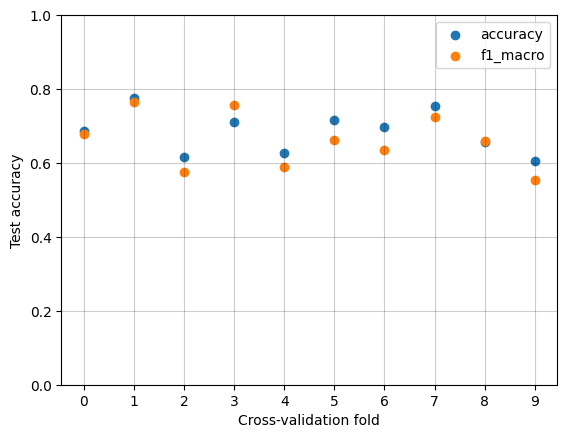

In [62]:
#| include: true
#| label: fig-cv-clf
#| fig-cap: 10-fold cross-validation results of the species classification Random Forest
#|   model. The average accuracy is 0.69 with a standard deviation of 0.05. The average
#|   macro F-score is 0.66 with a standard deviation of 0.07.

metrics = ["accuracy", "f1_macro"]

cv_result = cross_validate(
    estimator=clf,
    X=sfs.transform(X),
    y=y,
    cv=10,
    scoring=metrics,
)

fig, ax = plt.subplots()
for metric in metrics:
    ax.scatter(range(10), cv_result[f"test_{metric}"], label=metric)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel("Cross-validation fold")
ax.set_ylabel("Test accuracy")
ax.legend()
ax.grid(alpha=0.2, color="k")

In [70]:
for k, v in cv_result.items():
    print(f"{k:>15}: {v.mean():.2f} +- {v.std():.2f}")

       fit_time: 1.10 +- 0.02
     score_time: 0.01 +- 0.00
  test_accuracy: 0.69 +- 0.05
  test_f1_macro: 0.66 +- 0.07
